<a href="https://colab.research.google.com/github/DenisKai7/tobacco/blob/model/Tobacco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/tobacco dataset'
labels_csv_file = '_classes.csv'

In [17]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
full_labels_csv_path = os.path.join(dataset_path, labels_csv_file)

In [5]:
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


In [19]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 50
THRESHOLD = 0.5

In [20]:
L2_REGULARIZATION_FACTOR = 0.0001

In [21]:
data = []
labels_df = None
image_filenames = []
CLASS_NAMES = []
NUM_CLASSES = 0

try:
    print(f"Membaca file CSV dari: {full_labels_csv_path}")
    labels_df = pd.read_csv(full_labels_csv_path)
    print(f"Total entri dalam CSV: {len(labels_df)}")

    label_columns = labels_df.columns[1:].tolist()
    CLASS_NAMES = label_columns
    NUM_CLASSES = len(CLASS_NAMES)
    print(f"Ditemukan {NUM_CLASSES} kelas/label: {CLASS_NAMES}")

    for index, row in labels_df.iterrows():
        filename = row['filename']
        img_path = os.path.join(dataset_path, filename)

        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

                img = img / 255.0
                data.append(img)
                image_filenames.append(filename)
            else:
                print(f"Peringatan: Tidak dapat membaca gambar (None Type) dari {img_path}. Lewati.")
        except Exception as e:
            print(f"Error memproses {img_path}: {e}. Lewati.")

    data = np.array(data)

    labels_df_filtered = labels_df[labels_df['filename'].isin(image_filenames)].copy()
    labels_df_filtered = labels_df_filtered.set_index('filename').loc[image_filenames].reset_index()

    target = labels_df_filtered[label_columns].values.astype(np.float32)

    print(f"Total gambar yang berhasil dimuat dan diproses: {len(data)}")
    if len(data) == 0:
        print("Tidak ada gambar yang berhasil dimuat. Pastikan jalur gambar di CSV dan folder dataset sudah benar.")

        raise SystemExit("Error: Tidak ada gambar yang berhasil dimuat. Periksa jalur dan integritas file.")

    X_train, X_temp, y_train, y_temp = train_test_split(
        data, target, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    print(f"Ukuran data training: {len(X_train)} gambar")
    print(f"Ukuran data validation: {len(X_val)} gambar")
    print(f"Ukuran data test: {len(X_test)} gambar")

    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
    validation_generator = val_test_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

except FileNotFoundError:
    print(f"Error: File CSV '{labels_csv_file}' tidak ditemukan di '{dataset_path}'.")
    print("Pastikan nama file CSV dan jalurnya benar.")
    raise SystemExit("Error: File CSV tidak ditemukan.")
except KeyError as e:
    print(f"Error: Kolom yang dibutuhkan ('filename' atau label-kolom lainnya) tidak ditemukan di CSV Anda. Detail: {e}")
    print("Pastikan CSV Anda memiliki kolom 'filename' dan nama-nama kolom label yang benar.")
    raise SystemExit("Error: Kolom CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi kesalahan tak terduga selama pemrosesan data: {e}")
    raise SystemExit(f"Error tak terduga saat memuat data: {e}")

Membaca file CSV dari: /content/drive/MyDrive/tobacco dataset/_classes.csv
Total entri dalam CSV: 1052
Ditemukan 3 kelas/label: [' alternaria alternata', ' cercospora nicotianae', ' no cercospora nicotianae or alternaria alternata present']
Peringatan: Tidak dapat membaca gambar (None Type) dari /content/drive/MyDrive/tobacco dataset/healthy-19-_jpg.rf.b9da9de7f23c1358984b7f5b9678c3be.jpg. Lewati.
Peringatan: Tidak dapat membaca gambar (None Type) dari /content/drive/MyDrive/tobacco dataset/healthy-19-_jpg.rf.ca21b531209f1b4b74c3c76e8b9dd84c.jpg. Lewati.
Peringatan: Tidak dapat membaca gambar (None Type) dari /content/drive/MyDrive/tobacco dataset/healthy-17-_jpg.rf.0233c58edbeb917f735ef3f569142207.jpg. Lewati.
Peringatan: Tidak dapat membaca gambar (None Type) dari /content/drive/MyDrive/tobacco dataset/healthy-17-_jpg.rf.0609a0d02999d1420688015c7f4cd569.jpg. Lewati.
Peringatan: Tidak dapat membaca gambar (None Type) dari /content/drive/MyDrive/tobacco dataset/healthy-17-_jpg.rf.0b4be

In [22]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_FACTOR)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,203 (72.61 MB)

 Trainable params: 19,035,203 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
print("\nMemulai pelatihan model...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_val) // BATCH_SIZE
)


Memulai pelatihan model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3986 - loss: 0.8724 - val_accuracy: 0.4922 - val_loss: 0.5689
Epoch 2/30
 1/22 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2188 - loss: 0.6555

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.2188 - loss: 0.6555 - val_accuracy: 0.3672 - val_loss: 0.5565
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.5110 - loss: 0.5536 - val_accuracy: 0.4531 - val_loss: 0.5450
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.5000 - loss: 0.5834 - val_accuracy: 0.4531 - val_loss: 0.5508
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5640 - loss: 0.5032 - val_accuracy: 0.4531 - val_loss: 0.5437
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5312 - loss: 0.5836 - val_accuracy: 0.4609 - val_loss: 0.5288
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.5990 - loss: 0.5073 - val_accuracy: 0.4688 - val_loss: 0.4779
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.6562 - loss: 0.4206 - val_accuracy: 0.4844 - val_loss: 0.4949
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.6521 - loss: 0.4336 - val_accuracy: 0.5859 - val_loss: 0.4

In [11]:
print("\nMengevaluasi model pada test set...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Subset Accuracy: {accuracy:.4f}")


Mengevaluasi model pada test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step - accuracy: 0.7984 - loss: 0.2516
Test Loss: 0.2708
Test Subset Accuracy: 0.7792


In [13]:
y_pred_probs = model.predict(X_test)

y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

print("\nDetail Evaluasi Multi-Label:")

print("Classification Report (per label, ambang batas 0.5):")
print(classification_report(y_test, y_pred_binary, target_names=CLASS_NAMES, zero_division=0))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step

Detail Evaluasi Multi-Label:
Classification Report (per label, ambang batas 0.5):
                                                           precision    recall  f1-score   support

                                     alternaria alternata       0.64      0.77      0.70        47
                                    cercospora nicotianae       0.81      0.66      0.73        71
 no cercospora nicotianae or alternaria alternata present       0.92      0.94      0.93        36

                                                micro avg       0.77      0.76      0.77       154
                                                macro avg       0.79      0.79      0.79       154
                                             weighted avg       0.78      0.76      0.77       154
                                              samples avg       0.75      0.76      0.75       154




Confusion Matrix per Label:

Label:  alternaria alternata


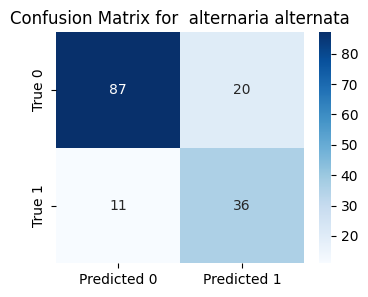


Label:  cercospora nicotianae


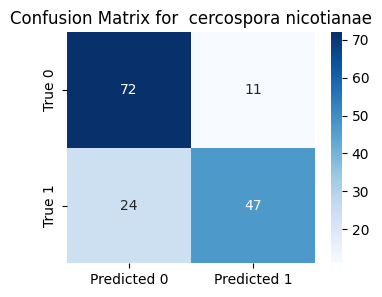


Label:  no cercospora nicotianae or alternaria alternata present


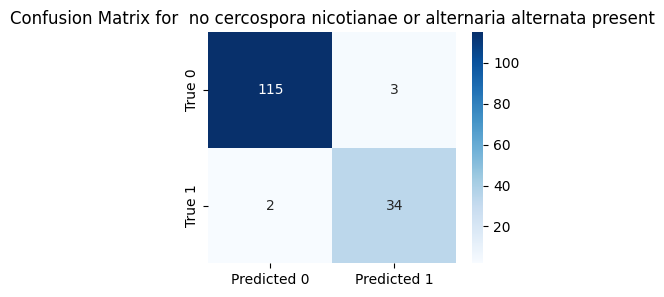

In [14]:
print("\nConfusion Matrix per Label:")
for i, class_name in enumerate(CLASS_NAMES):
    print(f"\nLabel: {class_name}")
    cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.show()

In [15]:
print(f"\nMicro F1-score: {f1_score(y_test, y_pred_binary, average='micro'):.4f}")
print(f"Macro F1-score: {f1_score(y_test, y_pred_binary, average='macro'):.4f}")
print(f"Micro Precision: {precision_score(y_test, y_pred_binary, average='micro', zero_division=0):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_pred_binary, average='macro', zero_division=0):.4f}")
print(f"Micro Recall: {recall_score(y_test, y_pred_binary, average='micro', zero_division=0):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_pred_binary, average='macro', zero_division=0):.4f}")



Micro F1-score: 0.7672
Macro F1-score: 0.7864
Micro Precision: 0.7748
Macro Precision: 0.7907
Micro Recall: 0.7597
Macro Recall: 0.7908


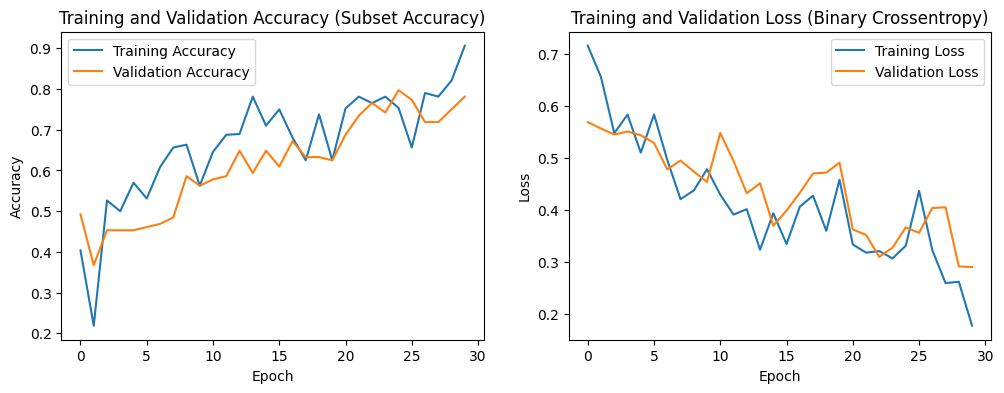

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Subset Accuracy)')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Binary Crossentropy)')
plt.show()
